# Exact Diagonalization of a 1D Spin Chain
<b> Christina Lee

Category: Grad

Prerequisites: Many-Body Quantum Mechanics, Part 1 </b>

Check out part 1 for the theory background.  Today is all programming.

Here we will initialize how many spins we will have in our chain.  

Remember to keep a reasonable number.  

Your number of states goes as $2^n$, and the size of your Hamiltonian will goes as $4^n$.  A 10-spin chain will already have over a million entries, before taking into account our tricks.

On my machine that has 16Gb of RAM and 3.2 GHz Intel i5 processor:

| n | m_z | t (min) | Memory (Gb) |
|---|-----|---------|-------------|
|16 | 8   | 1.5     | 2           |
|18 | 9   | ?       |  >16        |
|18 | 8   | 32.1    |   15.5      |

I included a file in this directory, ED.jl, that is the functional, rather than demonstrative, version of the code here.  For running large $n$, I recommend using that.  

In [4]:
using PyPlot

Here went enter one parameter `n`, the number of spins in our chain.

The parameter `nstates` is automatically calculated given `n`.


In [89]:
n=8
nstates=2^n

256

First. let's write out all our possible states in the $S^z$ basis.

In [90]:
psi=collect(0:(nstates-1))
for p in psi
    println(bin(p,n),' ',p)
end

00000000 0
00000001 1
00000010 2
00000011 3
00000100 4
00000101 5
00000110 6
00000111 7
00001000 8
00001001 9
00001010 10
00001011 11
00001100 12
00001101 13
00001110 14
00001111 15
00010000 16
00010001 17
00010010 18
00010011 19
00010100 20
00010101 21
00010110 22
00010111 23
00011000 24
00011001 25
00011010 26
00011011 27
00011100 28
00011101 29
00011110 30
00011111 31
00100000 32
00100001 33
00100010 34
00100011 35
00100100 36
00100101 37
00100110 38
00100111 39
00101000 40
00101001 41
00101010 42
00101011 43
00101100 44
00101101 45
00101110 46
00101111 47
00110000 48
00110001 49
00110010 50
00110011 51
00110100 52
00110101 53
00110110 54
00110111 55
00111000 56
00111001 57
00111010 58
00111011 59
00111100 60
00111101 61
00111110 62
00111111 63
01000000 64
01000001 65
01000010 66
01000011 67
01000100 68
01000101 69
01000110 70
01000111 71
01001000 72
01001001 73
01001010 74
01001011 75
01001100 76
01001101 77
01001110 78
01001111 79
01010000 80
01010001 81
01010010 82
01010011 83
01

As in Part 1, we will be using the powers of 2 and the masks I described to perform operations on numbers.  So we don't have to calculate them each time, we just store them in memory.

In [91]:
powers2=collect(0:(n-1));
powers2=2.^powers2;

mask=[0;powers2]+[powers2;0];
mask=[mask[2:end-1];[1+2^(n-1)]]
for m in mask
    println(bin(m,n))
end

00000011
00000110
00001100
00011000
00110000
01100000
11000000
10000001


`m` will be an array that will store the magnetization of each state.   See Part 1 for more explanation of how this works.  

In Part 1, I just talked about counting the number of up-spins as magnetization.   That's not true.  An up-spin is $+1/2$ and a down-spin is $-1/2$.  So we have to just modify our magnetization a little.

In [92]:
M2=zeros(Float64,nstates,nstates)

256×256 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [81]:
for ii in 1:length(psi)
    p=psi[ii]
    mp=sum(p&powers2./powers2)
    
    for jj in 1:n
        flipped=p$mask[jj]
        if sum((flipped&powers2)./powers2) == mp
            M[ii,flipped+1]=.5
            M[flipped+1,ii]=.5
            println(bin(p,n),'\t',bin(flipped,n))
        end
            
    end
end


001	010
001	100
010	001
010	100
011	101
011	110
100	010
100	001
101	110
101	011
110	101
110	011


In [93]:
for ii in 1:length(psi)
    p=psi[ii]
    mp=sum(p&powers2./powers2)
        for jj in 1:n
            jj2=(jj)%n+1
            if ((p&powers2[jj])./powers2[jj]) != ((p&powers2[jj2])./powers2[jj2])
            
                flipped=p$mask[jj]
                
            
                M2[ii,flipped+1]=.5
                M2[flipped+1,ii]=.5
            println(jj,'\t',jj2,'\t',bin(mask[jj],n),'\t',bin(p,n),'\t',bin(flipped,n))
            end

        end
end

1	2	00000011	00000001	00000010
8	1	10000001	00000001	10000000
1	2	00000011	00000010	00000001
2	3	00000110	00000010	00000100
2	3	00000110	00000011	00000101
8	1	10000001	00000011	10000010
2	3	00000110	00000100	00000010
3	4	00001100	00000100	00001000
1	2	00000011	00000101	00000110
2	3	00000110	00000101	00000011
3	4	00001100	00000101	00001001
8	1	10000001	00000101	10000100
1	2	00000011	00000110	00000101
3	4	00001100	00000110	00001010
3	4	00001100	00000111	00001011
8	1	10000001	00000111	10000110
3	4	00001100	00001000	00000100
4	5	00011000	00001000	00010000
1	2	00000011	00001001	00001010
3	4	00001100	00001001	00000101
4	5	00011000	00001001	00010001
8	1	10000001	00001001	10001000
1	2	00000011	00001010	00001001
2	3	00000110	00001010	00001100
3	4	00001100	00001010	00000110
4	5	00011000	00001010	00010010
2	3	00000110	00001011	00001101
3	4	00001100	00001011	00000111
4	5	00011000	00001011	00010011
8	1	10000001	00001011	10001010
2	3	00000110	00001100	00001010
4	5	00011000	00001100	00010100
1	2	0000

In [94]:
vals2=eigvals(M2);

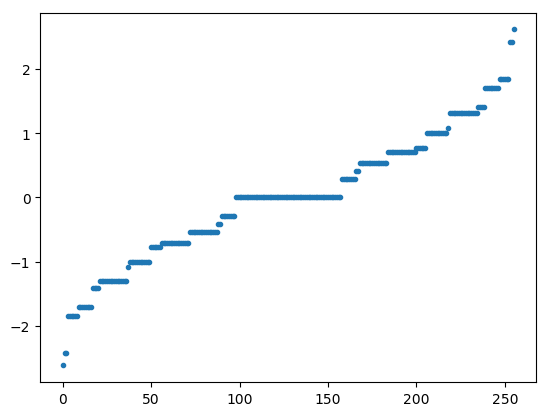

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000001FA1F4A8>

In [95]:
plot(vals2,".")

# Grouped by Magnetization

Now that we have the magnetizations corresponding to each state, we perform the trickery that allows us to dramatically reduce the difficulty of our problem. 

Magnetization is a conserved quantity, so we know that the Hamiltonian is not going to mix states of different magnetizations.   So we only have to deal with one magnetization at a time, which is a much smaller problem.  

First, we are going to sort our states by magnetization.

In [ ]:
ind=sortperm(m)
m=m[ind]
psi=psi[ind]
[psi m]

But even though they're now sorted, they're still mashed all together.  Now we want to pull them apart.

That's why we're are going to create an <b>Array of Arrays</b>.  Each elememt in `psia` will store all the states of a given magnetization.  

Why don't we just create a two dimensional array?

Because each element has a different length.  

The number of states at a given magnetization is given by a 

In [ ]:
ma=collect(0:.5:n/2.)-n/4
    
psia=Array{Array{Int64}}(n+1)
first=1
last=1
for i in 1:(n+1)
    psia[i]=psi[first:last]
    
    #now we compute them for the next round
    first=last+1
    last=last+binomial(n,i)
end
psia

In [ ]:
mz=11

dim=binomial(n,mz-1)

#M=ma[i]*(ma[i]+1)*eye(Float64,dim,dim)
M=zeros(Float64,dim,dim);

In [ ]:
Psi=psia[mz]
for p in Psi
    println(bin(p,n),' ',p)
end

In [ ]:
M

In [ ]:
eig11=eigvals(M)

In [25]:
function findstate(state::Int,set::Array{Int})
    iimin=1
    iimax=length(set)
    
    if set[iimin] == state
        return iimin
    end
    if set[iimax] == state
        return iimax
    end
    
    
    found=false
    count=0
    
    while found==false && count < length(set)
        count+=1
        index=floor(Int,iimin+(iimax-iimin)/2)
        if state < set[index]
            iimax=index-1
        elseif state > set[index]
            iimin=index+1
        else
            found=true
            return index
        end
    end
    
    if found == false
        println("findstate never found a match")
        println("Are you sure the state is in that Array?")
    end
    
    return 0
end

findstate (generic function with 1 method)

In [ ]:
v=eigvecs(M)

In [ ]:
temp=v[:,1]

for ii in 1:length(temp)
    if temp[((0:(length(temp)-1))+ii)%length(temp)+1]==temp
        println(ii)
    end
end

In [ ]:
((0:9)+2)%10+1

In [ ]:
lambdap=eigvals(M)

In [ ]:
length()

In [ ]:
eigall=[eig1;eig2;eig3;eig4;eig5;eig6;eig7;eig8;eig9;eig10;eig11];

In [ ]:
eigall=sort(eigall);

In [ ]:
plot(eigall)
xtemp=collect(1:length(eigall))
ytemp=(-acos(xtemp*2/length(eigall)-1)+pi/2)*pi/2
plot(xtemp,ytemp)

In [ ]:
plot(lambda)
xtemp=collect(1:length(lambda))
ytemp=(-acos(xtemp*2/length(lambda)-1)+pi/2)*pi/2
plot(xtemp,ytemp)

In [ ]:
xtemp*2/length(lambda)-1